# Importing files necessary for the code

In [1]:
import seaborn as sns
import datetime as dt
import matplotlib as mpl
import numpy as np
import pandas as pd
import scipy, json, csv, time, pytz
import matplotlib.pyplot as plt
import os
from google.cloud import bigquery
from google.oauth2 import service_account
from scipy.stats.mstats import zscore
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('fivethirtyeight')
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest 
from datetime import datetime,tzinfo
from pytz import timezone
seed = 135
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# Reading the Data

In [2]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS']="assistant1-366df-b820599fde13.json"
client = bigquery.Client()

# Query to transfer the date records into a dataframe

In [3]:
chunk_1 = """
SELECT 
   DATE(TIMESTAMP_MILLIS(timestamp)) AS Date,
   COUNT(transactions) AS Transactions
FROM `bigquery-public-data.bitcoin_blockchain.blocks`
GROUP BY date
HAVING date >= '2011-08-12' AND date <= '2020-08-12'
ORDER BY date
"""
job_1 = client.query(chunk_1)
iterator_1 = job_1.result(timeout=40)
rows_1 = list(iterator_1)
df_1 = pd.DataFrame(data=[list(x.values()) for x in rows_1], columns=list(rows_1[0].keys()))

# Query to transfer the Output_Satoshis, Blocks, Transaction records into another dataframe 

In [4]:
chunk_2 = """
SELECT
  o.Date,
  COUNT(o.block) AS Blocks,
  SUM(o.output_price) AS Output_Satoshis
FROM (
  SELECT
    DATE(TIMESTAMP_MILLIS(timestamp)) AS Date,
    output.output_satoshis AS output_price,
    block_id AS block
  FROM
    `bigquery-public-data.bitcoin_blockchain.transactions`,
    UNNEST(outputs) AS output ) AS o
GROUP BY
  o.date
HAVING o.date >= '2011-08-12' AND date <= '2020-08-12'
ORDER BY o.date, blocks
"""
job_2 = client.query(chunk_2)
iterator_2 = job_2.result(timeout=40)
rows_2 = list(iterator_2)
df_2 = pd.DataFrame(data=[list(x.values()) for x in rows_2], columns=list(rows_2[0].keys()))
df_2["Output_Satoshis"]= df_2["Output_Satoshis"].apply(lambda x: float(x/100000000))

# Merging the above two dataframes as "result"

In [5]:
result = pd.merge(df_1, df_2[['Date', 'Blocks', 'Output_Satoshis']],on='Date')
result.Transactions.to_numpy().sum()

399985

# Setting the Outlier Fraction and fitting the data

In [6]:
data = result[['Output_Satoshis','Blocks','Transactions']]
outliers_fraction=0.05
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
model =  IsolationForest(contamination=outliers_fraction)
model.fit(data)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination=0.05,
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

# Calling the IsolationForest() method from sklearn

In [7]:
result['res_anomaly'] = pd.Series(model.predict(data))
result['res_anomaly'] = result['res_anomaly'].apply(lambda x: x == -1)
result['res_anomaly'] = result['res_anomaly'].astype(int)
result['res_anomaly'].value_counts()

0    2457
1     130
Name: res_anomaly, dtype: int64

# Visualizations for Anomalies in Total Transactions, Blocks and Satoshis against Total days

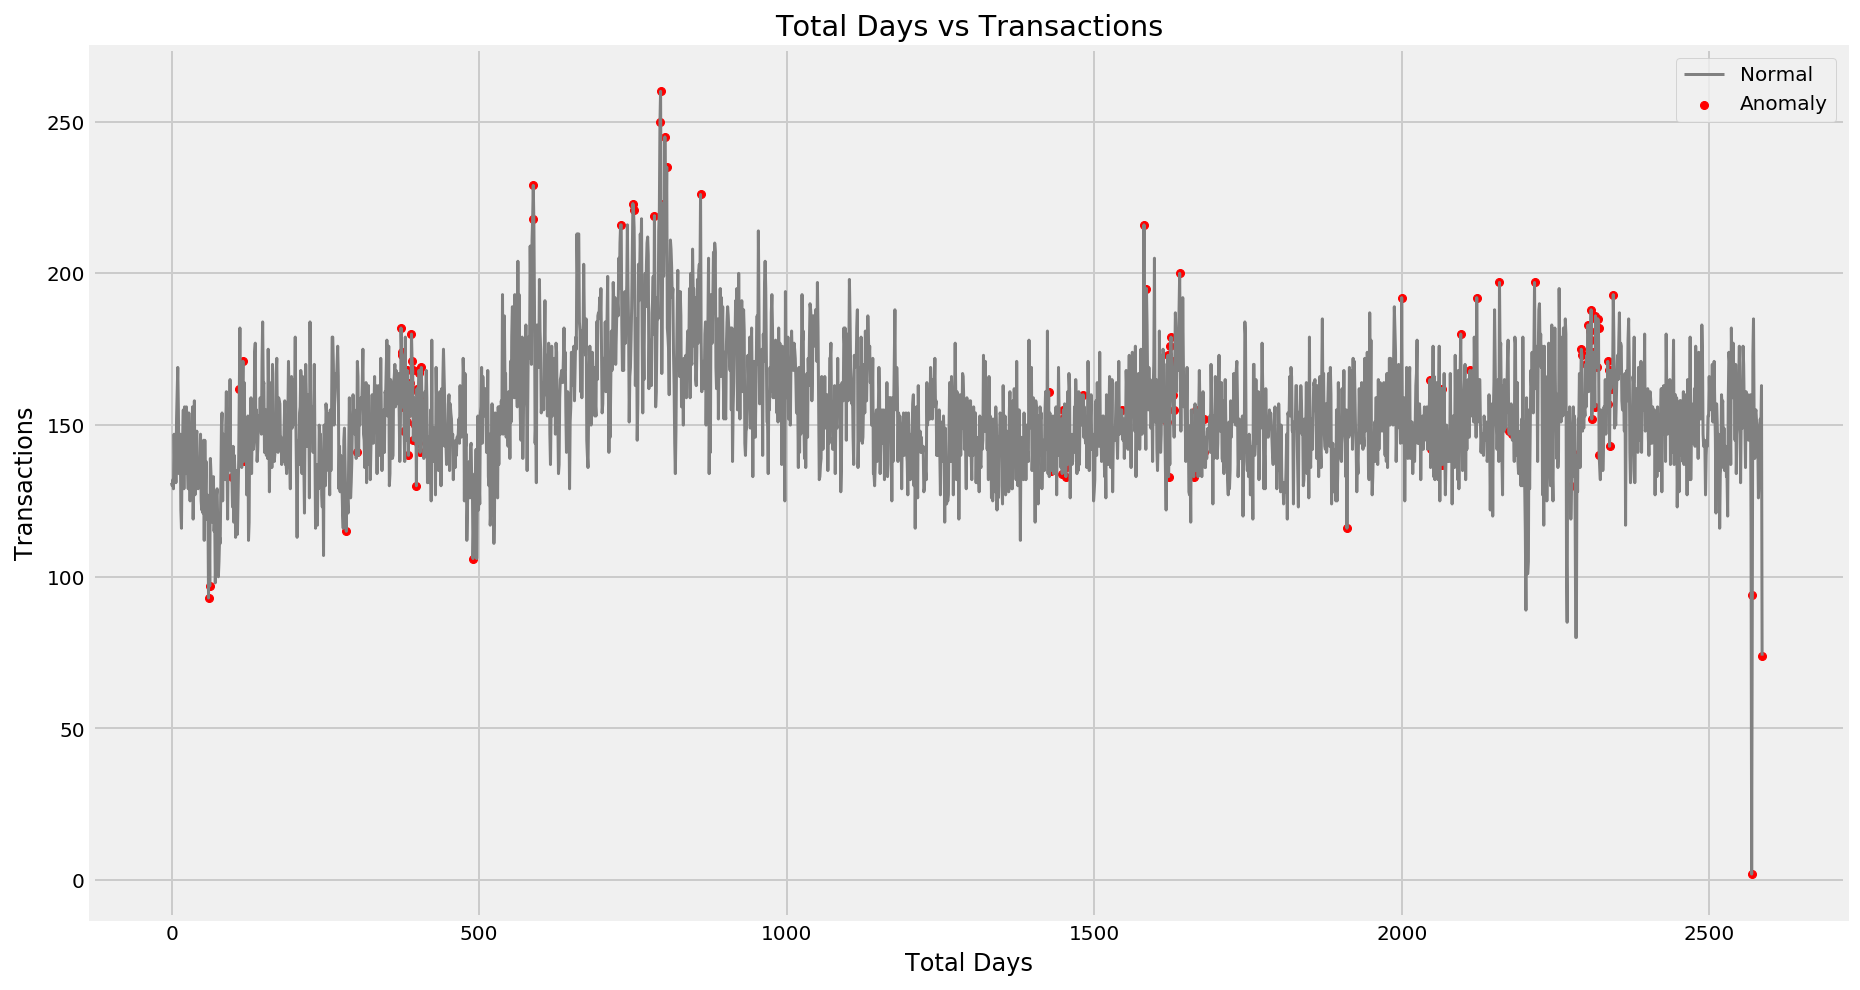

In [8]:
fig, ax = plt.subplots(figsize=(14,8))
a = result.loc[result['res_anomaly'] == 1]
ax.plot(result['Transactions'], color='gray', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Transactions'], color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title("Total Days vs Transactions")
plt.xlabel('Total Days')
plt.ylabel('Transactions')
plt.show()

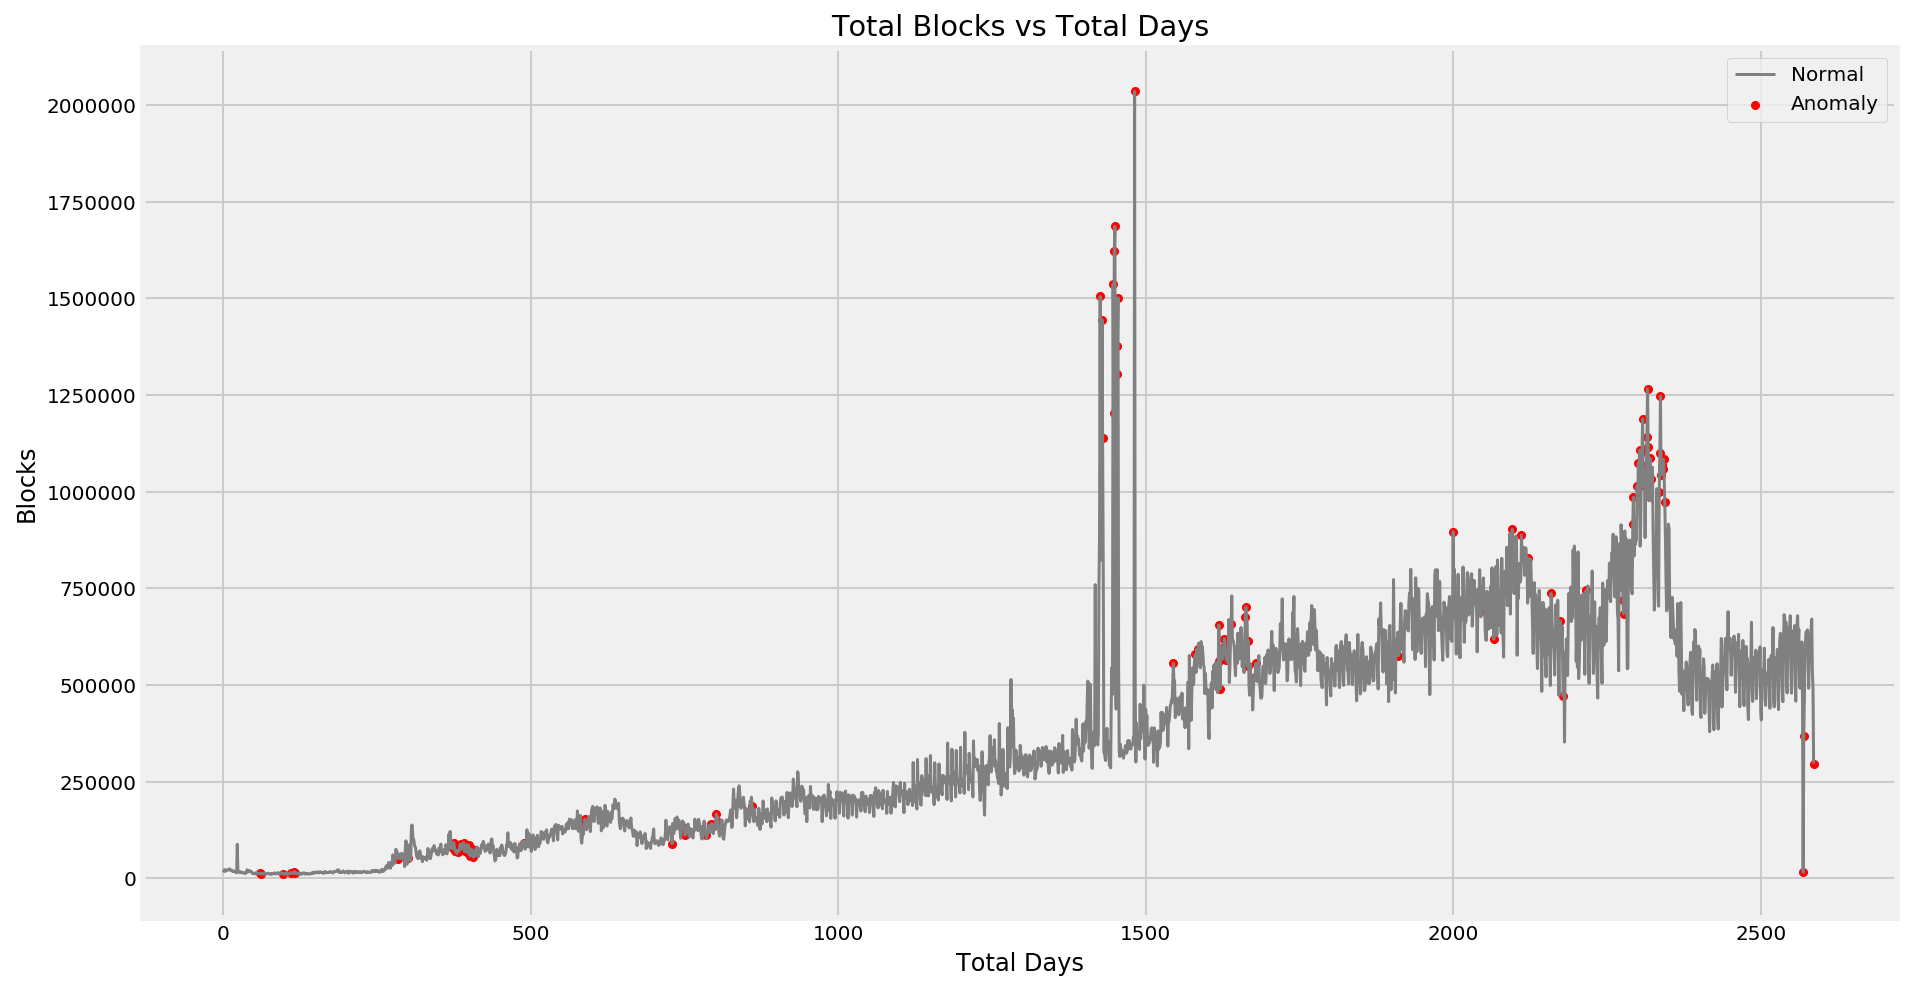

In [9]:
fig, ax = plt.subplots(figsize=(14,8))
a = result.loc[result['res_anomaly'] == 1]
ax.plot(result['Blocks'], color='gray', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Blocks'], color='red', label = 'Anomaly', s=16)
plt.legend()
plt.title("Total Blocks vs Total Days")
plt.xlabel('Total Days')
plt.ylabel('Blocks')
plt.show()

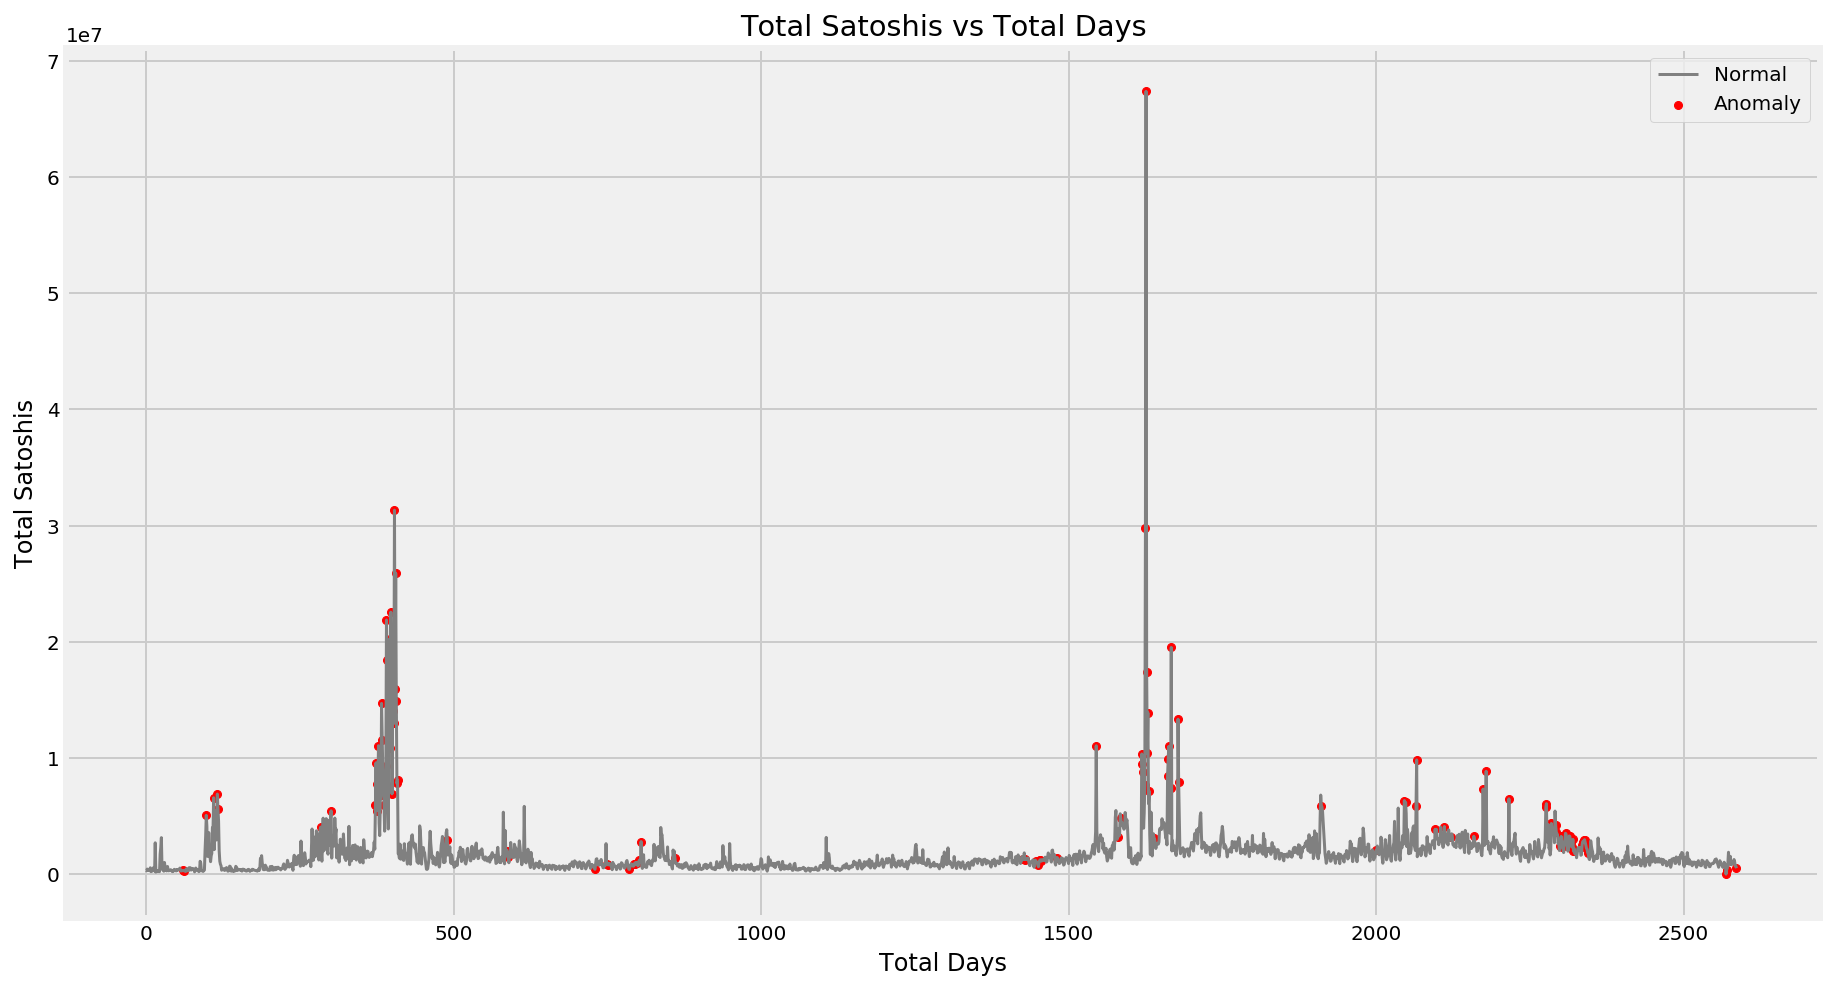

In [10]:
fig, ax = plt.subplots(figsize=(14,8))
a = result.loc[result['res_anomaly'] == 1]
ax.plot(result['Output_Satoshis'], color='gray', label = 'Normal', linewidth=1.5)
ax.scatter(a.index ,a['Output_Satoshis'], color='red', label = 'Anomaly', s=16)
plt.legend();
plt.title("Total Satoshis vs Total Days")
plt.xlabel('Total Days')
plt.ylabel('Total Satoshis')
plt.show()